# Section notes: Linear regression
Notes by Grace H. Zhang (2022), Xinyi Cai (2021), and Jacob Quinn Shenker (2020). These notes were heavily inspired by [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686), which I cannot recommend highly enough. See also a [pymc3 implementation](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html) of the outlier-detection mixture model described in that paper.

You can download this page in [Jupyter notebook .ipynb format](w08-section.ipynb). You can also download a [notebook to work with](w08-section-scratch.ipynb) during section.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import logsumexp
%config InlineBackend.figure_format = 'retina'

In [7]:
X_LABEL = "Concentration (ng/uL)"
Y_LABEL = "A260"

## Setting up the problem

It is a common occurence in a biology lab to need to measure the concentration of nucleic acids in a sample. Many cloning protocols (e.g., PCR) and sequencing reactions (e.g., RNA-Seq) only work optimally with specific concentrations of nucleic acids, so these protocols all involve measuring the current concentration of your sample and diluting accordingly. In most labs, the instrument used to measure the concentration of nucleic acids is a spectrophotometer. Since nucleic acids absorb ultraviolet light at 280nm, the spectrophotometer can infer the amount of DNA or RNA present by shining 280nm light through the sample and measuring how much is absorbed. The quantity that the instrument outputs is the absorbance:

$$\mathrm{absorbance}=-\log_{10}\frac{\mathrm{intensity}_\mathrm{sample}}{\mathrm{intensity}_\mathrm{blank}}$$ where $\mathrm{intensity}_\mathrm{blank}$ is the amount of transmitted light for a sample without any DNA.

From Beer's law (remember high school chemistry?), we know that the concentration of the sample should be proportional to the absorbance, so we can say that $\mathrm{concentration}=\mathrm{factor}\cdot\mathrm{absorbance}$ for some calibration factor. Note that absorbance is unitless and the calibration factor has units of ng/µL. The spectrophotometer manual states that double-stranded DNA should have a calibration factor of 50 ng/µL.

Because the ThermoFisher NanoDrop is the “Kleenex” of spectrophotometers, taking a measurement is often called “nanodropping” your samples. The NanoDrop is also known for two other features: being extremely expensive ($10k) and producing absolutely garbage data (biologists often complain that the NanoDrop is nothing more than a “really expensive random number generator”). As a thrifty scientist, you decide to save your lab some money by buying an old NanoDrop off ebay. You don't trust the calibration factor listed in the manual, so you want to measure it yourself and ensure that the instrument can accurately measure DNA concentrations.

You take DNA of a known concentration and you make various dilutions of it. You end up with samples of known concentrations spanning a wide range of concentrations. For each sample, you measure absorbance at 260nm (which we will call “A260”). You take a look at your data and it looks... very noisy. You're disheartened, but you don't give up. You email your data to your colleagues Sofía, Li, Fatma, and Nozomi and ask them to try measuring the calibration factor.

**Below is the code used to generate your absorbance data. Feel free to read it to understand how these synthetic data are generated, but otherwise you can skip it.**

In [9]:
def generate_random_data(num_points, num_replicates, m=1/50, b=0, x_min=5, x_max=800,
                         mistake_probabilities=(0.8, 0.0, 0.2),
                         multiplicative_error=0, additive_error=1):
    # an array of with values 0/1/2
    # 0: normal measurement
    # 1: erroneous measurement (uniformly random)
    # 2: sample is empty
    measurement_type = np.random.choice(3, p=mistake_probabilities, size=(num_points, num_replicates))
    # normal measurements
    xs = np.random.uniform(x_min, x_max, size=num_points)
    xs_with_replicates = np.repeat(xs[:,np.newaxis], num_replicates, axis=1)
    ys_normal_without_noise = m * xs + b
    ys_normal = (ys_normal_without_noise[:,np.newaxis]
                    * np.random.normal(1, multiplicative_error, size=(num_points, num_replicates))
                    + np.random.normal(0, additive_error, size=(num_points, num_replicates)))
    # erroneous measurements
    y_min, y_max = m * np.array([x_min, x_max]) + b
    ys_erroneous = np.random.uniform(y_min, y_max, size=(num_points, num_replicates))
    # add multiplicative and additive error terms in quadrature
    empty_error = np.sqrt((multiplicative_error * y_max)**2 + additive_error**2)
    # empty sample measurements
    ys_empty = np.random.normal(0, empty_error, size=(num_points, num_replicates))
    ys = ((measurement_type == 0) * ys_normal
                        + (measurement_type == 1) * ys_erroneous
                        + (measurement_type == 2) * ys_empty)
    # add multiplicative and additive error terms in quadrature
    sigma_ys = np.sqrt((multiplicative_error * ys)**2 + additive_error**2)
    return xs_with_replicates, ys, sigma_ys

def prepare_data(xs, ys, sigma_ys, average_replicates=True):
    if average_replicates:
        xs = np.mean(xs, axis=1)
        sigma_ys = stats.sem(ys, axis=1)
        ys = np.mean(ys, axis=1)
    else:
        # include each replicate as a separate observation
        xs = xs.reshape(-1)
        ys = ys.reshape(-1)
        sigma_ys = sigma_ys.reshape(-1)
    data_ary = np.array([xs, ys, sigma_ys]).T
    data_df = pd.DataFrame(data_ary, columns=["conc", "A260", "sigma_A260"])
    return data_df

## Generating the data

Every time you run `generate_random_data`, it generates new synthetic data (here, we generate 3 replicate measurements for each of 20 DNA concentrations). We then use `prepare_data` to turn the output of `generate_random_data` into a pandas DataFrame. Note that `prepare_data` takes an `average_replicates` flag. When `average_replicates=True`, we take all the replicates for a single DNA concentration and replace them with a single data point (whose mean is the sample mean of the replicates, and whose error bar is the standard error of the mean of the replicates). When `average_replicates=False`, we include each individual replicate as its own data point, and all data points are assigned equal error bars.

You can run `generate_random_data` once to randomly generate data, and re-run `prepare_data` as many times as you want for the same synthetic dataset to observe how `average_replicates` affects the results in the rest of this notebook.

Note that `generate_random_data` takes many arguments that allow you to change the amount of measurement error, range of the data, and assumed calibration factor.

In [10]:
np.random.seed(732) # comment this out to generate new random data!
data_replicates = generate_random_data(12, 3)

In [11]:
data_no_avg = prepare_data(*data_replicates, average_replicates=False)

In [12]:
data_avg = prepare_data(*data_replicates, average_replicates=True)

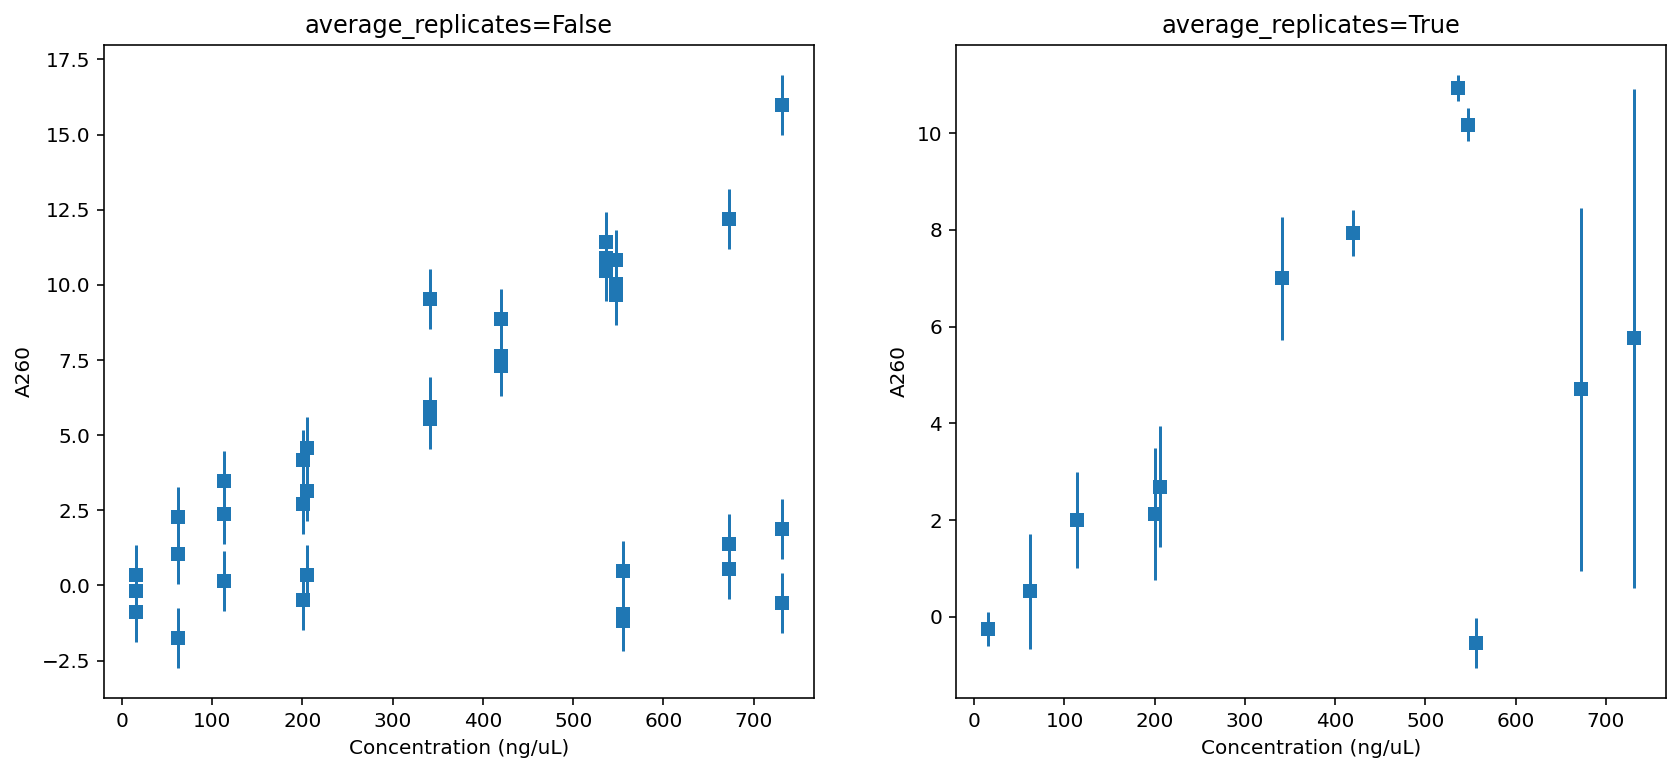

In [13]:
fig = plt.figure(figsize=(14,6))
plots = {"average_replicates=False": data_no_avg, "average_replicates=True": data_avg}
for plot_num, (title, d) in enumerate(plots.items()):
    ax = fig.add_subplot(1, 2, plot_num + 1)
    ax.errorbar(d["conc"], d["A260"], d["sigma_A260"], fmt="s")
    ax.set_title(title)
    plt.xlabel(X_LABEL)
    plt.ylabel(Y_LABEL);

For the remainder of this notebook, we're going to focus on `average_replicates=True`. After all, in your training as a scientist, you learned to do three replicates of every measurement and average the results! This is an extremely common procedure in science. Is it always the best thing to do? We will return to this issue later.

In [14]:
data = data_avg

## Four possible answers

Your colleagues email back, and each of them is convinced that they've correctly measured the calibration factor despite the noise in the data. Oh no, you think, they've all come up with different answers! Which is the “best” line? Which calibration factor should you use? Here are the plots each of them sent you:

In [15]:
lines = {"Sofía": (0.009, 1.09),
         "Li": (0.017, -0.25),
         "Fatma": (0.02, -0.59),
         "Nozomi": (0.013, 1.45)}

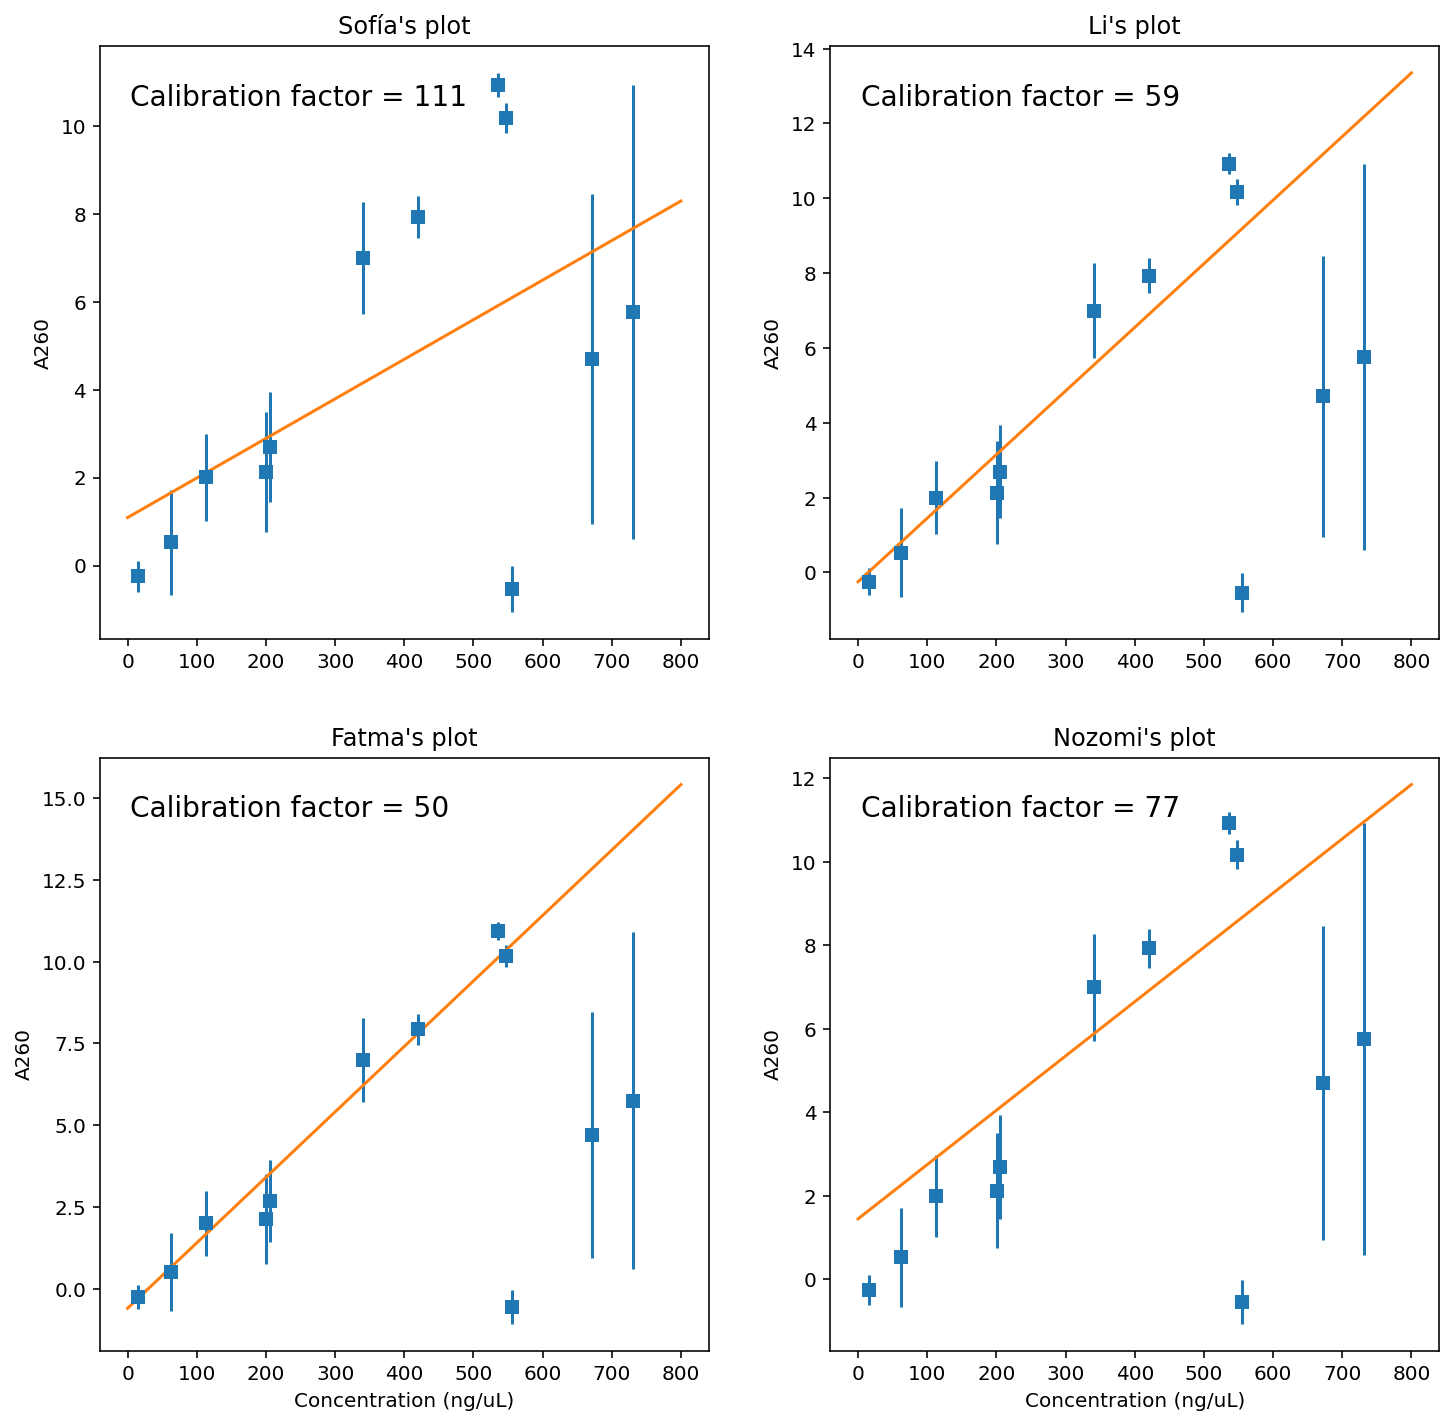

In [16]:
xs = np.linspace(0, 800, 10)
fig = plt.figure(figsize=(12,12))
for plot_num, (name, line) in enumerate(lines.items()):
    ax = fig.add_subplot(2, 2, plot_num + 1)
    ax.errorbar(data["conc"], data["A260"], data["sigma_A260"], fmt="s")
    ax.plot(xs, line[0] * xs + line[1])
    plt.text(0.05, 0.9, "Calibration factor = {:.0f}".format(1/line[0]), fontdict={"size": 14}, transform=ax.transAxes)
    ax.set_title(f"{name}'s plot")
    if plot_num >= 2: # only show x-axis label on bottom two plots, otherwise it overlaps with plot title
        plt.xlabel(X_LABEL)
    plt.ylabel(Y_LABEL);

## Define your objective

You email all of them back, asking them to argue why their line is the “best” linear model of the data.

- Sofía replies, “I used ordinary least squares.”
- Li replies, “I used weighted least squares”
- Fatma replies, “I saw some obvious outliers, so I threw those out before using ordinary least squares.”
- Nozomi replies, “I figured it was better to over-estimate than under-estimate, so I used an asymmetric loss function.”


When trying to come up with the best model, it's good to separate this task into two steps: first, define precisely what you mean by *best* (by writing down an objective function); second, design an algorithm to spit out a model that has the highest possible value of this objective function (sometimes called *optimization* or *model-fitting*).

As such, when two people disagree and each claim that their model is “better,” there are two possibilities:
1. They both wrote down the same objective function, but they ended up with different models. Settling these kinds of disagreements is easy: just evaluate the objective function for each of their models, and whoever has a higher value of the objective function has the better model. It's unlikely that two people could agree about the objective function but end up with different models for simple classes of models, but with extremely complicated models, fitting the model becomes a hard problem and requires fancy algorithms. These algorithms may not always converge, and/or are complex enough that there might be hard-to-catch bugs in their code.
2. They each chose a different objective function. Instead of arguing using imprecise, qualitative language (“my model handles outliers better”), you can directly compare the mathematical expressions of the objective functions (“my model penalizes errors linearly instead of quadratically, so it is less sensitive to outliers”). This doesn't make disagreements go away—two competent scientists can legitimately disagree about what the objective function should be—but it does make it extremely clear what they're disagreeing about.

Let's return to the problem: whenever you use your spectrophotometer to measure DNA concentration, you're going to need to decide which calibration factor to use to convert absorbance measurement (A260) to DNA concentration. You figure out what objective functions each of them used. 
1. Sofía and Li don't say what objective function they used, but the methods they use are ordinary least squares and weighted least squares (both assume a specific objective function). 
2. Fatma also used ordinary least squares but ignored some data points they thought were outliers—is that okay? (Throwing out data points is never okay but there is a principled way to do this, see below!) 
3. Nozomi said something about a “loss function”—does that have anything to do with the objective function? (Yes, see below!) Nozomi also explicitly mentioned their goal: they noted that it's usually a bigger problem to have too little DNA in an experiment rather than too much. Because they decided it was better to under-estimate the correction factor rather than over-estimate it, they surely wrote down an objective function that expressed that preference mathematically.

## Ordinary Least Squares

In lecture, Sean discussed how the formulae for ordinary least squares (OLS) regression follow from minimizing the residual sum of squares: $\mathrm{RSS}=\sum_i (\hat{y}_i - y_i)^2=\sum_i (m x_i - b - y_i)^2$, where $\hat{y}_i=m x_i + b$ is the linear model's prediction for data point $i$. For OLS, RSS is the objective function.

Sean also discussed how you can arrive at the exact same linear model ($m$ and $b$ values) by specifying a generative probabilistic model, writing down the corresponding likelihood function, and maximizing it. This approach is called *maximum likelihood estimation*. Recall:
1. We assumed that there is a mechanism that links some measured variable $x$ to an measured variable $y$ with an exactly linear relationship $y=mx+b$, and that $y$ is measured with Gaussian noise with mean 0 and variance $\sigma^2$, where $\sigma^2$ is known. Taken together, we conclude that $y_i\sim Normal(m x_i + b, \sigma^2)$.
2. We wrote down the likelihood $$P(\mathrm{data} | OLS, m, b)=\prod_i \frac{1}{\sqrt{2\sigma^2\pi}}e^{-\frac{(m x_i - b - y_i)^2}{2\sigma^2}}$$.
3. By taking the log of both sides, taking the derivative and setting it equal to zero, we maximized the log-likelihood analytically. This isn't too hard for the simple case of a linear model with Gaussian measurement errors of known variance, but quickly becomes confusing for more complicated models.

If you assume that each measurement has the same measurement error $\sigma$, you can get OLS by maximum likelihood estimation. 

## Weighted Least Squares

If instead of $y_i\sim Normal(m x_i + b, \sigma^2)$, you assume each measurement has a different error $\sigma_i$, this leads to a generative probabilistic model $y_i\sim Normal(m x_i + b, \sigma_i^2)$, and you get weighted least squares (WLS) regression.

This is a minor tweak to our generative probabilistic model, with the new likelihood given by
$$P(\mathrm{data} | WLS, m, b)=\prod_i \frac{1}{\sqrt{2\sigma_i^2\pi}}e^{-\frac{(m x_i - b - y_i)^2}{2\sigma_i^2}}$$,
but it requires that we go through the math to maximize the log-likelihood all over again. If we keep making changes to our generative probabilistic model, you worry think that doing all this math over and over again will be slow and tiresome. Let's make the computer do some of this hard work for us, and maximize the likelihood numerically instead of analytically.
<br>(We will use the `scipy.optimize.minimize` function.)

## Least squares with maximum likelihood

Because $\log x$ is a monotonic function (it always goes up, never goes down, for increasing $x$ values), maximizing the log-likelihood is equivalent to maximizing the likelihood. Scipy's optimizers minimize, so instead of maximizing the log-likelihood, we'll minimize the negative log-likelihood (“NLL”). 
<br>If we have a set of 2D data (x, y):

In [17]:
# here we define the negative log-likelihood
def nll_slow(params, xs, ys, sigmas):
    ll = 0
    # params is a numpy array of length two containing m and b
    m = params[0]
    b = params[1]
    # for each data point, add a term to the log-likelihood
    for i in range(len(xs)):
        y_pred = m * xs[i] + b
        residual = ys[i] - y_pred
        # this is equivalent to stats.norm.logpdf(ys[i], loc=y_pred, scale=sigmas[i])
        ll += stats.norm.logpdf(residual, loc=0, scale=sigmas[i])
    return -ll # return negative log-likelihood

Instead of looping over each data point individually (if we have high-dimensional data), we can calculate each term of the log-likelihood all at once by passing in numpy arrays into stats.norm.logpdf, and getting back a numpy array of the same length containing logpdf values (we just need to sum them). Using vectorization often results in more readable code, and for large datasets will be much faster. If you like, you can check that `nll_slow` produces the same answer as `nll` given the same arguments.

In [20]:
def nll(params, xs, ys, sigmas):
    m, b = params
    y_pred = m * xs + b
    ll_terms = stats.norm.logpdf(ys - y_pred, loc=0, scale=sigmas)
    return -ll_terms.sum()

Now we use `scipy.optimize.minimize` to minimize our log-likelihood. We pass in the function to optimize, an initial guess for the parameter values (`m` and `b`), and a tuple (or list) of arguments to be passed to your function (in this case, the x data, y data, and y error bars). In simple problems, the initial guess often doesn't matter; it often does matter for more complex problems. (Can you think of how you might avoid problems here? Recall how you handled initial parameters in the k-means problem set!)

In [19]:
guess = np.array([0, 0]) # guess for m and b

sigma_y = 1 # assume equal errors for all points

minimization_ols = optimize.minimize(nll, guess, (data["conc"], data["A260"], sigma_y))
m = minimization_ols.x[0]
b = minimization_ols.x[1]
print(f"OLS with maximum likelihood: y = {m:.3f}x + {b:.2f}")
# calculate the y values predicted by our linear model
predicted_ols = m * data["conc"] + b

OLS with maximum likelihood: y = 0.009x + 1.09


In [21]:
guess = np.array([0, 0]) # guess for m and b

sigma_y = data["sigma_A260"] # use measurement errors given in data file

minimization_wls = optimize.minimize(nll, guess, (data["conc"], data["A260"], sigma_y))
m = minimization_wls.x[0]
b = minimization_wls.x[1]
print(f"WLS with maximum likelihood: y = {m:.3f}x + {b:.2f}")
# calculate the y values predicted by our linear model
predicted_wls = m * data["conc"] + b

WLS with maximum likelihood: y = 0.017x + -0.25


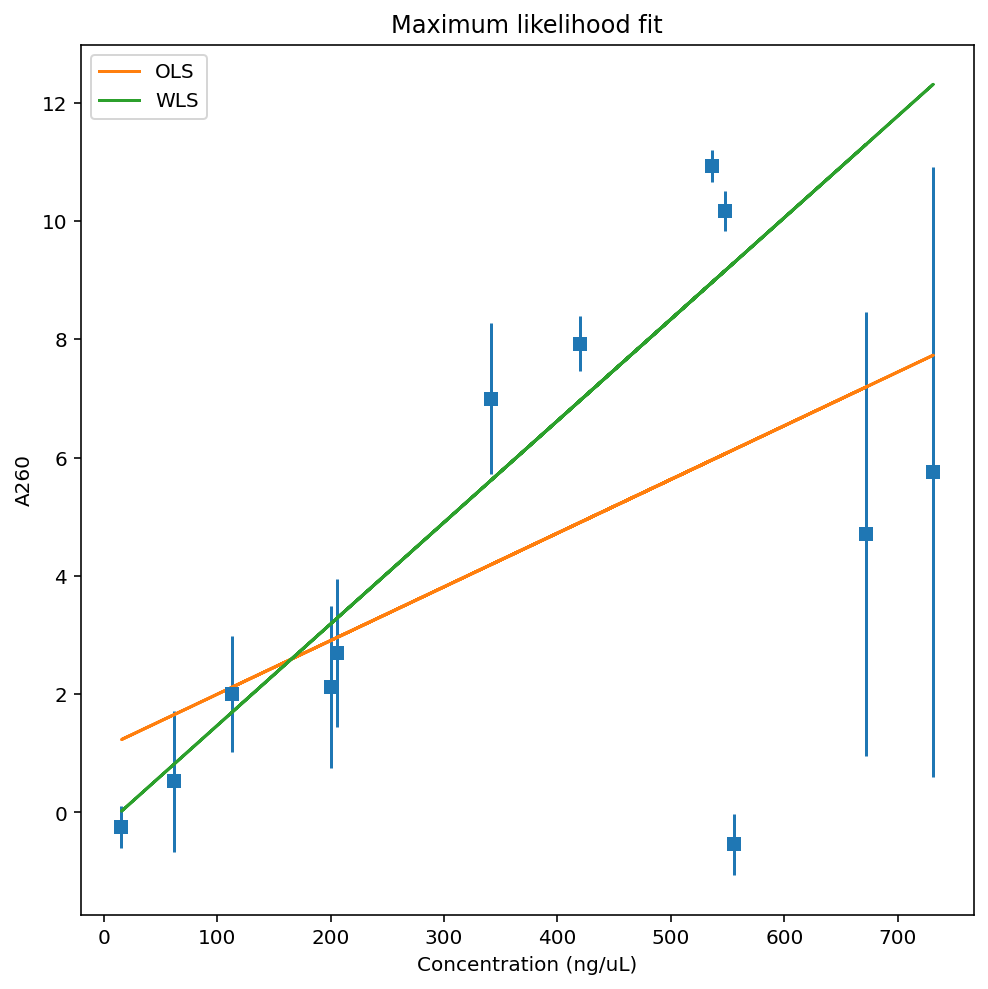

In [22]:
fig = plt.figure(figsize=(8,8))
plt.errorbar(data["conc"], data["A260"], data["sigma_A260"], fmt="s")
plt.plot(data["conc"], predicted_ols, label="OLS")
plt.plot(data["conc"], predicted_wls, label="WLS")
plt.title("Maximum likelihood fit")
plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL);

Note that in our generative probabilistic model we have assumed that the two physical quantities $x$ and $y$ are exactly linearly related, and that we measure $x$ perfectly and $y$ with some error. This is not the same as assuming that both quantities are measured perfectly, but that the relationship between $x$ and $y$ is only approximately linear! In many cases, when scientists fit linear models, what they *really* want to assume is the latter, but that's not what least-squares fitting does! (However, this latter assumption is vague. What does “approximately linear” mean? That's why you need to specify your generative probabilistic model, because that's an articulation of what you mean by *approximately* linear.) Least-squares also assumes that you measure one of your variables ($x$) perfectly but the other with significant measurement error ($y$). No measurement is perfect, so ignoring measurement error in $x$ is a big assumption—sometimes a decent one, sometimes a poor one.

## Comparing fits with likelihood ratios

Maybe you can say that the WLS fit looks “better” by eye than the OLS fit, but that's a vague statement. What is better? And how much better? Recall that the likelihood is defined as a probability: the probability of the data being generated by a model with specific parameter values: $P(\mathrm{data}|\mathrm{model},\theta=\theta_0)$. As such, we can define a likelihood ratio which describes how much more likely it is that a model with parameter values $\theta_1$ will generate the observed data relative to the same model with parameter values $\theta_2$. In our case, let's compare how likely the WLS best-fit line is relative to the OLS bet-fit line according to the *OLS* likelihood function

$$\mathrm{likelihood~ratio}=\frac{P(\mathrm{data}|\mathrm{OLS~model},m=m_\mathrm{WLS},b=b_\mathrm{WLS})}{P(\mathrm{data}|\mathrm{OLS~model},m=m_\mathrm{OLS},b=b_\mathrm{OLS})}$$

Careful, this is a ratio of likelihoods, not log-likelihoods or negative log-likelihoods!

In [23]:
sigma_y = 2 # try changing this!
nll_wls = nll(minimization_wls.x, data["conc"], data["A260"], sigma_y)
nll_ols = nll(minimization_ols.x, data["conc"], data["A260"], sigma_y)
likelihood_ratio = np.exp((-nll_wls) - (-nll_ols))
# equivalent to
#likelihood_ratio = np.exp(-nll_wls) / np.exp(-nll_ols)
print("The WLS fit parameters are {:.2e} times as likely as the OLS fit parameters according to the OLS likelihood function".format(likelihood_ratio))

The WLS fit parameters are 8.32e-05 times as likely as the OLS fit parameters according to the OLS likelihood function


Note that the likelihood ratio depends on what you assume for the measurement error on the y values! This may be slightly surprising because the OLS best-fit $m$ and $b$ parameters do *not* depend on this $\sigma_y$. To see why this makes sense, consider that in the limit of very large error bars, the likelihood ratio should tell you that it doesn't really prefer one line or the other. Try changing `sigma_y` above and see how the answer changes.

Why does this say that the WLS best-fit line is *less likely* than the OLS best-fit line? Isn't WLS supposed to be “better”? Again, the way we specify what we mean by *better* is by writing down an objective function (here, a likelihood) that describes our goal and our assumptions. According to the OLS likelihood function, the OLS best-fit line is 10,000x better than the WLS best-fit line. This shouldn't be surprising, because to get the OLS best-fit line, we maximized the OLS likelihood function. Similarly. Each choice of a likelihood function. There is no way to determine which line is “better” without specifying a specific likelihood function that encodes your hhh.

You may wonder how the OLS and WLS best-fit lines compare according to the WLS likelihood function,
$$\mathrm{likelihood~ratio}=\frac{P(\mathrm{data}|\mathrm{WLS~model},m=m_\mathrm{WLS},b=b_\mathrm{WLS})}{P(\mathrm{data}|\mathrm{WLS~model},m=m_\mathrm{OLS},b=b_\mathrm{OLS})}.$$
Because the WLS likelihood function is the same as the OLS likelihood function except each data point gets its own $\sigma$, we can do this calculation by calling the same `nll` function as before but by specifying a vector of $\sigma$ values from our dataset. As expected, the WLS best-fit line is much more likely than the OLS best-fit line if you assume that the measurement errors given by the data file are correct.

In [52]:
nll_wls = nll(minimization_wls.x, data["conc"], data["A260"], data["sigma_A260"])
nll_ols = nll(minimization_ols.x, data["conc"], data["A260"], data["sigma_A260"])
likelihood_ratio = np.exp((-nll_wls) - (-nll_ols))
print("The WLS fit parameters are {:.2e} times as likely as the OLS fit parameters according to the WLS likelihood function".format(likelihood_ratio))

The WLS fit parameters are 2.03e+59 times as likely as the OLS fit parameters according to the WLS likelihood function


## Outliers

Fatma looked at some of your data points, decided they were outliers, and threw them out. Then they fit a line with OLS. How do you decide if they did a good job of “throwing out outliers”? If you and Fatma disagree about which outliers should be discarded, how do you decide who is correct? Well, you should resolve this dispute the same way we've discussed that any statistical dispute should be discussed: both you and Fatma should articulate which objective function you used to optimize your selection of outliers, and argue about whose objective function makes most sense in this context. Unfortunately, Fatma probably didn't follow this kind of principled procedure when selecting outliers to discard, they probably just picked by eye—this is subjective and often introduces bias into your results. You could come up with a principled way to select outliers to discard. This is absolutely a good way to solve this problem. Perhaps you could try to come up with a good way to do this.

There is an alternative method which we will focus on. We begin by articulating what exactly we mean by *outlier*. Colloquially, an “outlier” refers to a data point that's far away from where a reasonable prediction might guess where it is. Essentially, you're implicitly assuming that sometimes your measurement process will generate values that are much further away than it usually does. We can express that assumption mathematically by saying that our measurement errors follow a probability distribution that has fatter tails than the Gaussian distribution. One such distribution that's commonly used in this context is a Student's t distribution.

Using a fat-tailed distribution like Student's t instead of a Gaussian distribution for your measurement errors is sometimes called *robust regression*. Recall that the Student's t distribution has mean $\mu$ and standard deviation $\sigma$ parameters, but it also has a third parameter called the degree-of-freedom $\nu$. You don't need to worry about exactly how to interpret $\nu$ values, all you need to know is that the tails are fattest when $\nu$ is close to 1 and thinnest when $\nu$ is large.

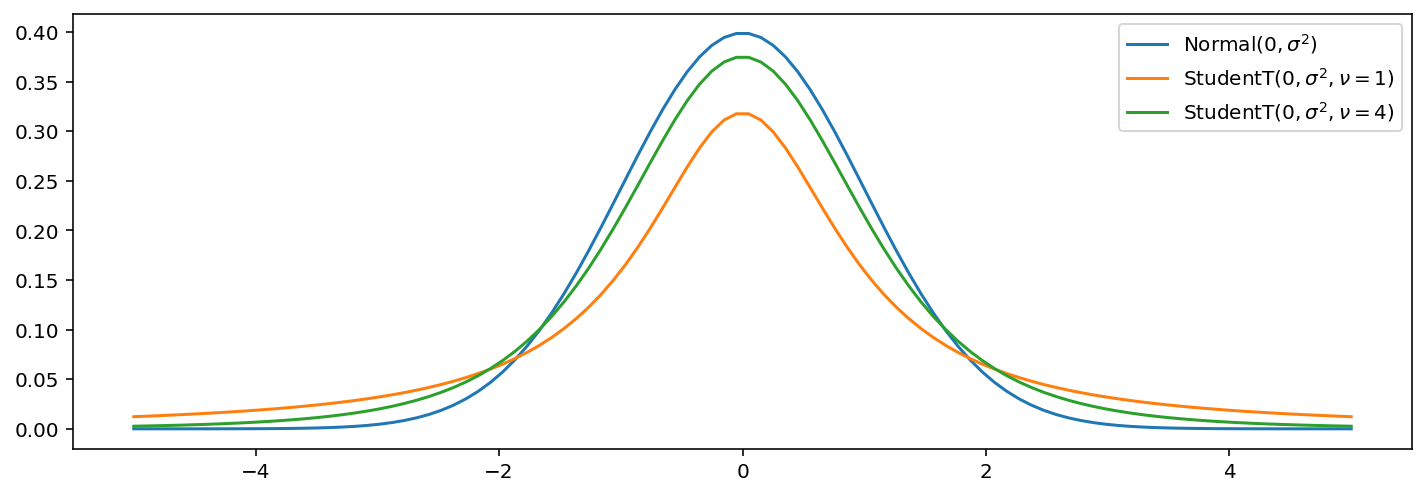

In [24]:
xs = np.linspace(-5, 5, 100)
plt.figure(figsize=(12,4))
plt.plot(xs, stats.norm.pdf(xs, loc=0, scale=1), label=r"$\mathrm{Normal}(0, \sigma^2)$")
plt.plot(xs, stats.t.pdf(xs, 1, loc=0, scale=1), label=r"$\mathrm{StudentT}(0, \sigma^2, \nu=1)$")
plt.plot(xs, stats.t.pdf(xs, 4, loc=0, scale=1), label=r"$\mathrm{StudentT}(0, \sigma^2, \nu=4)$")
plt.legend();

As you can see, the Gaussian curve has “thin tails,” Student's t with $\nu=4$ has slightly fatter tails, and Student's t with $\nu=1$ has much fatter tails. (The “fatness” of the tails refers to how much of the probability density lies far away from the mean of the distribution.) To perform robust regression on our data, we need to make a single change to our code: swap the `logpdf` of a Gaussian distribution with the `logpdf` of a Student's t distribution. Remember you also need to pass in the `studentt_dof` parameter into your `nll` function.

In [25]:
def nll_t(params, xs, ys, sigmas, studentt_dof):
    m, b = params
    y_pred = m * xs + b
    ll_terms = stats.t.logpdf(ys - y_pred, studentt_dof, loc=0, scale=sigmas)
    return -ll_terms.sum()

# guess for m and b
# see what happens if you guess [0, 0]
guess = np.array([0.02, 0])

sigma_y = data["sigma_A260"] # use measurement errors given in data file
studentt_dof = 4 # see how the results change if you change this

minimization_t = optimize.minimize(nll_t, guess, (data["conc"], data["A260"], sigma_y, studentt_dof))
m = minimization_t.x[0]
b = minimization_t.x[1]
print(f"Student's t regression: y = {m:.3f}x + {b:.2f}")
# calculate the y values predicted by our linear model
predicted_t = m * data["conc"] + b

Student's t regression: y = 0.020x + -0.59


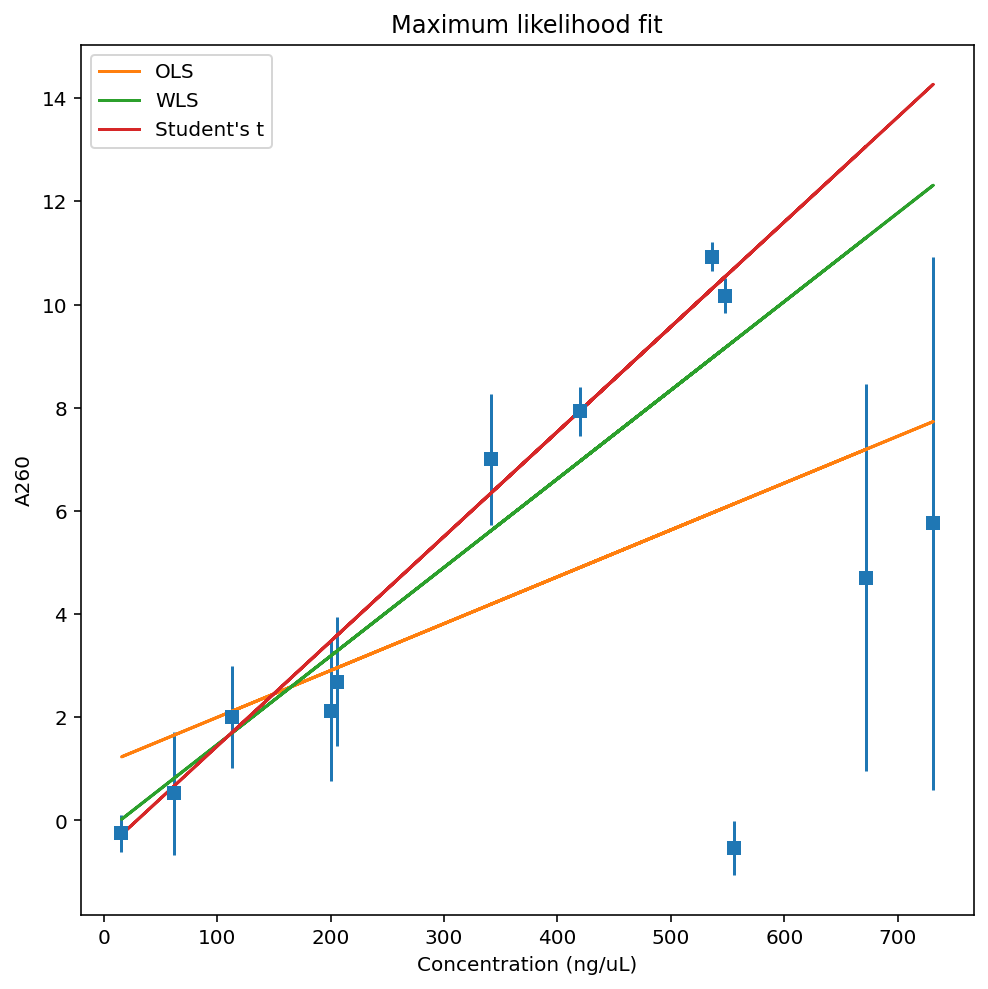

In [26]:
fig = plt.figure(figsize=(8,8))
plt.errorbar(data["conc"], data["A260"], data["sigma_A260"], fmt="s")
plt.plot(data["conc"], predicted_ols, label="OLS")
plt.plot(data["conc"], predicted_wls, label="WLS")
plt.plot(data["conc"], predicted_t, label="Student's t")
plt.title("Maximum likelihood fit")
plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL);

We see three data points that seem to be outliers: at ~550, ~675, and ~750 ng/µL. All three points are dragging the OLS line down, causing it to under-estimate the slope, and hence over-estimate the correction factor. The outliers at ~675, and ~750 ng/µL have larger error bars, so they receive a much smaller weighting in the WLS fit. However, the WLS line is still dragged down somewhat by the outlier at ~550 ng/µL, which has a small error bar, and hence still is given significant weight in the WLS fit. Because the Student's t distribution has fatter tails, it is more forgiving of outliers, so it is dragged down even less—which allows the Student's t best-fit line to accurately infer the slope, and hence the correction factor. Note that robust regression with the Student's t distribution isn't perfect—it's still biased by outliers, just to a lesser degree than a model that assumes Gaussian errors.

Note that robust regression with the Student's t distribution is a way to fit a linear model in the presence of outliers without manually picking specific outliers to throw out! You never made any subjective and unprincipled choices! You specified an objective function and then maximized it. Another scientist can argue with *why* you used a Student's t distribution as the error distribution in your generative probabilistic model, and maybe that was a good choice and maybe that was a bad choice, but that depends on how your data were collected.

## Asymmetric loss function

Will you always be optimizing a likelihood? No! It depends on what your goal is—what *objective function* you pick. Sometimes you only care about the *predictions* that your model makes. The primary goal of generative probabilistic modeling is accurately inferring the parameters of your generative model; if you care about making accurate predictions, you can just define what you mean by “prediction accuracy” and use that as your objective function. As a warm up, we start by minimizing the residual sum of squares between our model predictions and our data. Note that we have made no assumptions about how our data was generated (e.g., we have not defined a generative probabilistic model of our data, nor have we written down a likelihood function).

In [27]:
def residual_sum_of_squares(params, xs, ys):
    m, b = params
    y_pred = m * xs + b
    return ((ys - y_pred)**2).sum()

guess = np.array([0.02, 0]) # guess for m and b

minimization_rss = optimize.minimize(residual_sum_of_squares, guess, (data["conc"], data["A260"]))
m = minimization_rss.x[0]
b = minimization_rss.x[1]
print(f"Minimizing RSS: y = {m:.3f}x + {b:.2f}")
# calculate the y values predicted by our linear model
predicted_rss = m * data["conc"] + b

Minimizing RSS: y = 0.009x + 1.09


Notice that these are the same best-fit parameters as OLS. That makes sense, since (as Sean discussed in lecture), maximizing the OLS likelihood function ended up being equivalent to minimizing the RSS. RSS (sometimes called “quadratic loss” or “L2 norm”) is an extremely common way to value how good or poor predictions are, but it's not the only way! Recall that you are trying to calibrate your NanoDrop machine by measuring the 260nm absorbance (A260) of various solutions with known DNA concentration. In your experiments, when you measure the A260 of an unknown sample, you use this linear model to estimate DNA concentration from that A260 value. Since $\mathrm{A260}=m \cdot \mathrm{concentration} + b$, we can solve for concentration: $\mathrm{concentration}=\frac{1}{m}\cdot\mathrm{A260} - \frac{b}{m}$. Thus overestimating A260 means we underestimate concentration. You might want to make the assumption that underestimating concentration may be better than overestimating concentration, because often in cloning experiments having a little extra DNA in your reactions won't matter, but having too little DNA in your reactions will cause them to fail. You can modify your `residual_sum_of_squares` function to express this mathematically: that overestimating A260 is penalized four times more harshly than underestimating A260. This is an example of an *asymmetric loss function*. (In prediction-oriented fields like machine learning, the term *loss function* is often used interchangeably with *objective function*. Think of it as “how much money will I *lose* if I make a prediction error?”)

In [28]:
def asymmetric_rss(params, xs, ys):
    m, b = params
    y_pred = m * xs + b
    # if we overestimate, penalize at 1x weight; if we underestimate, penalize at 4x weight
    return np.where(y_pred - ys > 0, (ys - y_pred)**2, 4 * (ys - y_pred)**2).sum()

guess = np.array([0.02, 0]) # guess for m and b

minimization_asym = optimize.minimize(asymmetric_rss, guess, (data["conc"], data["A260"]))
m = minimization_asym.x[0]
b = minimization_asym.x[1]
print(f"Minimizing asymmetric loss: y = {m:.3f}x + {b:.2f}")
# calculate the y values predicted by our linear model
predicted_asym = m * data["conc"] + b

Minimizing asymmetric loss: y = 0.013x + 1.45


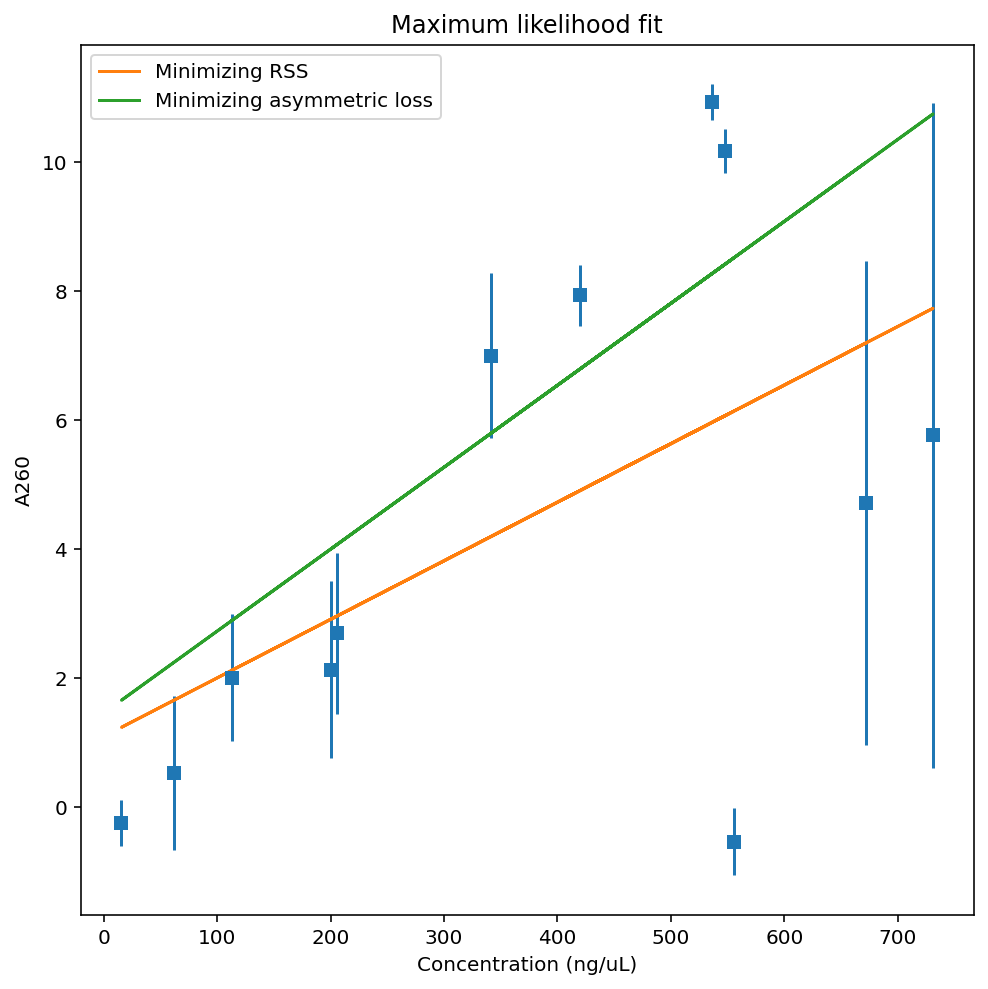

In [29]:
fig = plt.figure(figsize=(8,8))
plt.errorbar(data["conc"], data["A260"], data["sigma_A260"], fmt="s")
plt.plot(data["conc"], predicted_rss, label="Minimizing RSS")
plt.plot(data["conc"], predicted_asym, label="Minimizing asymmetric loss")
plt.title("Maximum likelihood fit")
plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL);

## Prediction vs. inference

Prediction and parameter inference are related, but fundamentally different tasks. Often the same statistical methods can be used to do both, but in many circumstances, you will approach your problem differently depending on whether prediction or parameter inference is your primary goal. The approach of *generative probabilistic modeling* is focused on writing down your best assumptions about the physical and biological process which generates the data you have collected in terms of a set of unknown parameters, and the machinery of Bayesian probability gives you tools for inferring those parameters. If your generative model is a good approximation of reality, then your model should also be good at predicting future data given the inferred parameters. However, for complicated physical and biological processes, writing down a model that accurately reflects reality often yields extremely complicated models with a large number of unknown parameters. Since it may be difficult to obtain precise parameter estimates for large numbers of unknown parameters with limited data, these models may offer poor predictive performance. A simpler approach, if you only care about predictive performance, is a simplified model with fewer parameters which doesn't attempt to faithfully describe the process of generating the data, but merely tries to predict measurements.

Further reading:
1. [Döring](https://www.datascienceblog.net/post/commentary/inference-vs-prediction/) provides a very readable blog post describing some differences between inference and prediction.
2. [Wu, Harris, and Mcauley (2008)](https://onlinelibrary.wiley.com/doi/abs/10.1002/cjce.5450850401) uses multiple regression as a case study to look at where simplified models may be worse at parameter inference but better at prediction.
3. [Breiman (2001)](https://projecteuclid.org/euclid.ss/1009213726) was one of the first to clearly address the distinction between statisticians and machine learning/data science practicioners in this highly-cited, influencial paper.
4. [Shmueli (2010)](https://projecteuclid.org/euclid.ss/1294167961) gives a more recent comparison between explanatory and predictive modeling.
5. [Sanders](https://hdsr.mitpress.mit.edu/pub/a7gxkn0a/release/5) uses publishing trends to investigate this dichotomy, focusing on industry.



## Parameter uncertainties

In [30]:
ms = np.linspace(0.01, 0.03, 100)
bs = np.linspace(-1.5, 1.5, 100)
sigmas = data["sigma_A260"].values[np.newaxis,np.newaxis,:]
predictions = ms[:,np.newaxis,np.newaxis] * data["conc"].values[np.newaxis,np.newaxis,:] + bs[np.newaxis,:,np.newaxis]
residuals = predictions - data["A260"].values[np.newaxis,np.newaxis,:]
rss = residuals.sum(axis=-1)
ll_terms = stats.norm.logpdf(residuals, loc=0, scale=sigmas)
ll = ll_terms.sum(axis=-1)
m_prior = stats.norm.logpdf(ms, loc=0.02, scale=0.01)
b_prior = stats.norm.logpdf(bs, loc=0, scale=1)
log_posterior = ll + m_prior[:,np.newaxis] + b_prior[np.newaxis,:]
log_posterior -= logsumexp(log_posterior)
posterior = np.exp(log_posterior)
likelihood = np.exp(ll)

Here is the joint likelihood.

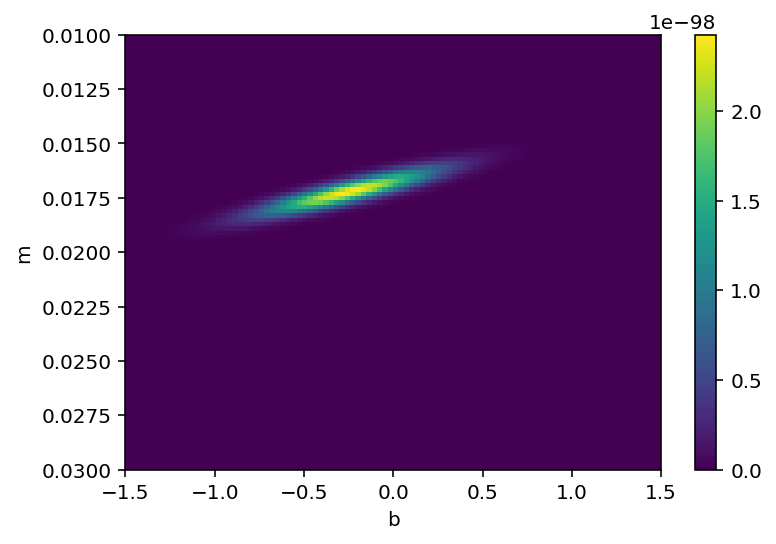

In [31]:
# extent=[left x-value, right x-value, top y-value, bottom y-value]
plt.imshow(likelihood, extent=[bs[0], bs[-1], ms[-1], ms[0]], aspect="auto")
plt.colorbar();
plt.xlabel("b")
plt.ylabel("m");

And here's the posterior, which is just the product of the likelihood and the prior probabilities of each of the parameters. Try adjusting the prior distributions to make them narrower, see if you can make the posterior look qualitatively different than the likelihood.

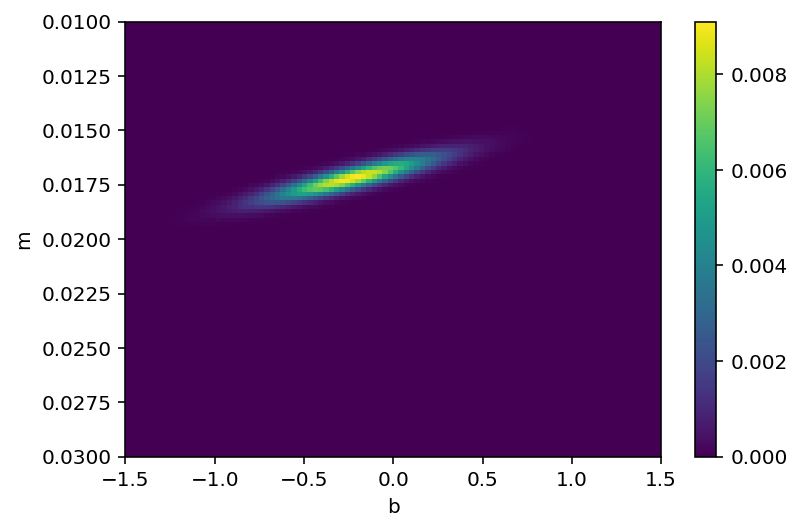

In [35]:
plt.imshow(posterior, extent=[bs[0], bs[-1], ms[-1], ms[0]], aspect="auto")
plt.colorbar();
plt.xlabel("b")
plt.ylabel("m");

We can also marginalize by summing our two-dimensional array of probabilities to get one-dimensional probabilities of each parameter separately.

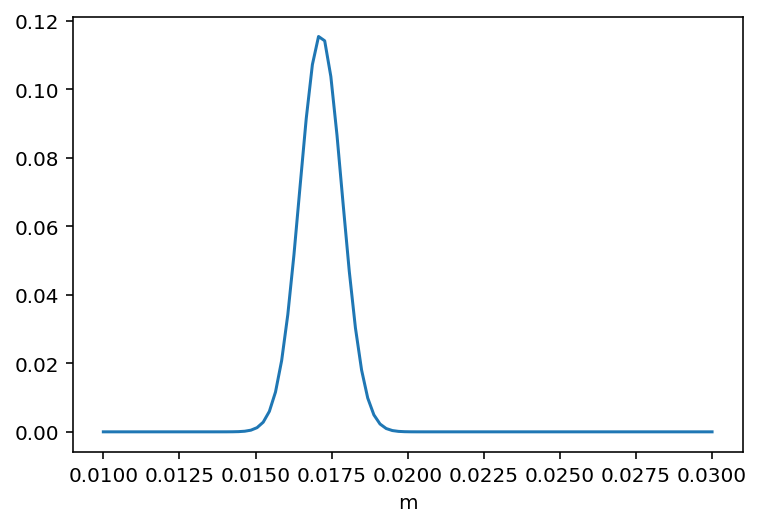

In [33]:
plt.plot(ms, posterior.sum(axis=1))
plt.xlabel("m");

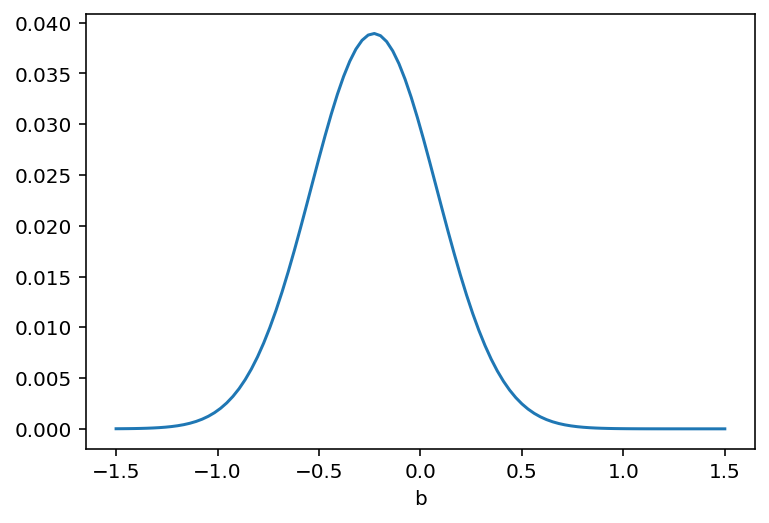

In [36]:
plt.plot(bs, posterior.sum(axis=0))
plt.xlabel("b");

## Prediction uncertainty

What happens if we make an A260 measurement and we want to know what our uncertainty in DNA concentration should be?

In [37]:
new_A260 = 11
new_predictions = (new_A260 - bs[np.newaxis,:,np.newaxis]) / ms[:,np.newaxis,np.newaxis]
new_predictions = new_predictions.reshape((-1,))
order = new_predictions.argsort()
sorted_predictions = new_predictions[order]
prediction_posterior = posterior.reshape((-1,))[order]

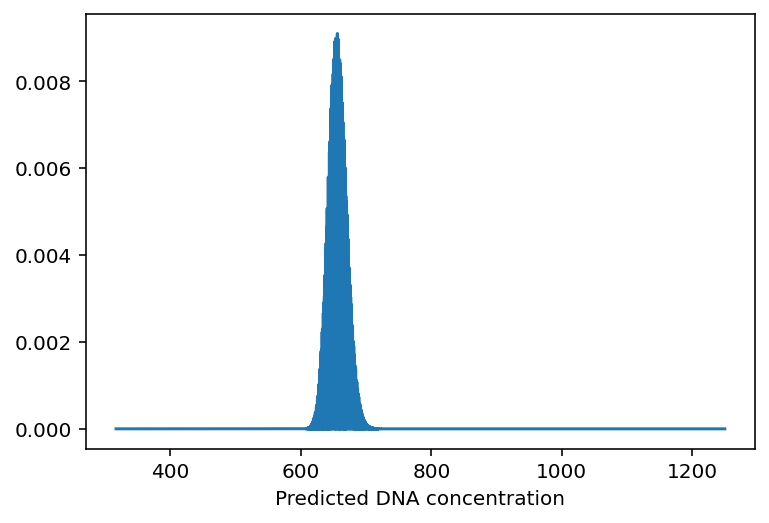

In [38]:
plt.plot(sorted_predictions, prediction_posterior)
plt.xlabel("Predicted DNA concentration");